In [1]:
################## 1. Download checkpoints and build models
import os
if os.path.exists('/content/VAR'): os.chdir('/content/VAR')
import os.path as osp
import torch, torchvision
import random
import numpy as np
from typing import List, Optional, Tuple, Union
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

# we recommend using imagenet-512-d36 model to do the in-painting & out-painting & class-condition editing task
MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====

assert MODEL_DEPTH in {16, 20, 24, 30, 36}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
FOR_512_px = MODEL_DEPTH == 36
if FOR_512_px:
    patch_nums = (1, 2, 3, 4, 6, 9, 13, 18, 24, 32)
else:
    patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=MODEL_DEPTH, shared_aln=FOR_512_px,
)

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'preparation finished.')


[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422


/tmp/ipykernel_1232930/1464891235.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
/tmp/ipyker

preparation finished.


In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.unit_mem import get_datasets
IMAGENET_PATH = '/home/woody/iwi1/iwi1106h/data/imagenet'

augs_per_img = 8
num_per_class = 32
num_classes = 32
random.seed(0)
classes = random.sample(range(1000), num_classes)
# each batch will be the same image with different augmentations
dataset, dataset_val = get_datasets(IMAGENET_PATH, num_per_class, classes, augs_per_img)
ds_by_index, ds_by_index_val = get_datasets(IMAGENET_PATH, num_per_class, classes, 1, no_crop=True)

ld_val = DataLoader(dataset_val, num_workers=0, batch_size=augs_per_img,)
ld = DataLoader(dataset, num_workers=0, batch_size=augs_per_img,)

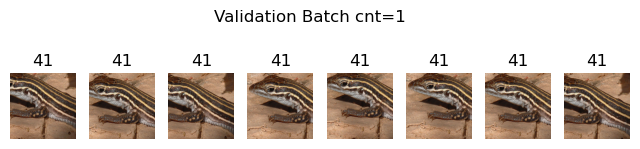

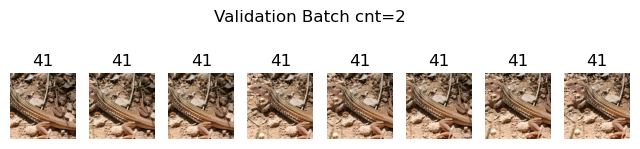

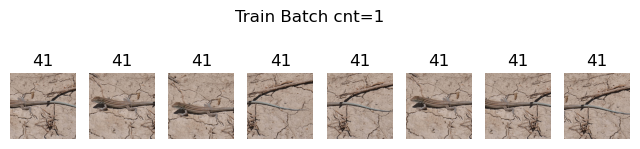

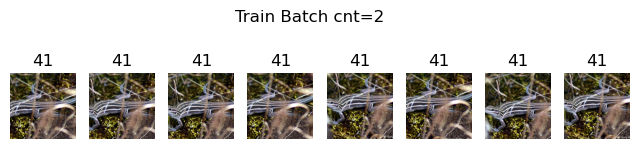

In [3]:
import matplotlib.pyplot as plt

def show_batch(images, labels, title):
    fig, axs = plt.subplots(1, augs_per_img, figsize=(augs_per_img, 2))
    fig.suptitle(title)
    for i in range(augs_per_img):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        axs[i].imshow((img + 1)/2.)
        axs[i].axis('off')
        axs[i].set_title(str(labels[i].item()))
    plt.show()

cnt = 0
for imgs, labels in ld_val:
    cnt += 1
    show_batch(imgs, labels, f"Validation Batch {cnt=}")
    if cnt > 1:  # show only one batch
        break

cnt = 0
for imgs, labels in ld:
    cnt += 1
    show_batch(imgs, labels, f"Train Batch {cnt=}")
    if cnt > 1:  # show only one batch
        break

In [4]:
print(var)

VAR(
  drop_path_rate=0.0666667
  (word_embed): Linear(in_features=32, out_features=1024, bias=True)
  (class_emb): Embedding(1001, 1024)
  (lvl_embed): Embedding(10, 1024)
  (shared_ada_lin): Identity()
  (blocks): ModuleList(
    (0): AdaLNSelfAttn(
      shared_aln=False
      (drop_path): Identity()
      (attn): SelfAttention(
        using_flash=False, using_xform=False, attn_l2_norm=True
        (mat_qkv): Linear(in_features=1024, out_features=3072, bias=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Identity()
      )
      (ffn): FFN(
        fused_mlp_func=False
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='tanh')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Identity()
      )
      (ln_wo_grad): LayerNorm((1024,), eps=1e-06, elementwise_affine=False)
      (ada_lin): Sequential(
        (0): SiLU()
        (1): Linear(in_featur

In [15]:
from torch import LongTensor, Tensor
import re
import warnings
import pandas as pd
from tqdm.notebook import tqdm
import os
activations = {}


# remove the handles if it crashed
if ('handles' in locals() or 'handles' in globals()) and handles:
    for h in handles:
        h.remove()

handles = []
for module_name, module in var.named_modules():
    if re.match(r'blocks\.\d{1,2}\.(attn\.proj$|ffn\.fc\d)', module_name):
        def hook_fn(module, input, output, name=module_name):
            if 'fc1' in name:
                output = torch.nn.functional.gelu(output, approximate='tanh')
            activations[name] = torch.abs(output)
        handles.append(module.register_forward_hook(hook_fn))

device = 'cuda'
batches = len(ld)
def get_data_for_loader(loader):
    activation_data = []
    for it, (inp_B3HW, label_B) in enumerate(tqdm(loader, total=batches, desc="Processing batches")):

        inp_B3HW = inp_B3HW.to(device)
        label_B = label_B.to(device)
        
        # from train_step
        B, V = label_B.shape[0], vae.vocab_size
        
        gt_idx_Bl: List[LongTensor] = vae.img_to_idxBl(inp_B3HW)
        gt_BL = torch.cat(gt_idx_Bl, dim=1)
        x_BLCv_wo_first_l: Tensor = vae.quantize.idxBl_to_var_input(gt_idx_Bl)
        
        logits_BLV = var(label_B, x_BLCv_wo_first_l)
        #loss = self.train_loss(logits_BLV.view(-1, V), gt_BL.view(-1)).view(B, -1)
        #loss = loss.mul(lw).sum(dim=-1).mean()
        
        # Now activations[var.head] contains the output of the head Linear layer
        for name, activation in activations.items():
            activation_data.append({
                'image_id': it,
                'class': label_B[0].item() if label_B.ndim == 1 else label_B.item(),
                'layer_name': name,
                'activations': torch.mean(activation, dim=(0, 1)).cpu().numpy()
            })
        

    return pd.DataFrame(activation_data)

if os.path.exists("activation_df.pkl") and os.path.exists("activation_df_val.pkl"):
    activation_df = pd.read_pickle("activation_df.pkl")
    activation_df_val = pd.read_pickle("activation_df_val.pkl")
    print("Loaded activation data from pickle files.")
else:
    activation_df = get_data_for_loader(ld)
    activation_df_val = get_data_for_loader(ld_val)
    activation_df.to_pickle("activation_df.pkl")
    activation_df_val.to_pickle("activation_df_val.pkl")
    print("Calculated and saved activation data.")


for handle in handles: handle.remove()

Loaded activation data from pickle files.


In [22]:
activation_df['layer_name'] = activation_df['layer_name'].apply(lambda x: re.sub(r'blocks\.(\d{1})\.', r'blocks.0\1.', x))
activation_df['ds'] = 'train'

#activation_df_val['layer_name'] = activation_df_val['layer_name'].apply(lambda x: re.sub(r'blocks\.(\d{1})\.', r'blocks.0\1.', x))
#activation_df_val['ds'] = 'val'

data_to_agg = activation_df
img_cnt = num_classes * num_per_class
#data_to_agg = pd.concat([activation_df, activation_df_val], ignore_index=True)
#img_cnt = num_classes * num_per_class * 2

agg_data = data_to_agg.groupby('layer_name').agg(
    layer_name=('layer_name', 'first'),
    normal_mean=('activations', 'mean'), # sanity check
    mu_mean_no_max=('activations', lambda x: (np.stack(x).mean(axis=0) * img_cnt - np.stack(x).max(axis=0))/(img_cnt - 1)),
    count=('activations', 'size'), # sanity check
    mu_max=('activations', lambda x: np.stack(x).max(axis=0)),
    mu_argmax=('activations', lambda x: np.stack(x).argmax(axis=0)), # The image producing the max activation
)

agg_data['unit_mem'] = (agg_data['mu_max']-agg_data['mu_mean_no_max']) / (agg_data['mu_max'] + agg_data['mu_mean_no_max'])
agg_data['avg_unit_mem'] = agg_data['unit_mem'].apply(lambda x: np.mean(x))
agg_data['max_unit_mem'] = agg_data['unit_mem'].apply(lambda x: np.max(x))
agg_data['layer_type'] = agg_data['layer_name'].str.extract(r'(attn.proj|ffn.fc1|ffn.fc2)$', expand=False)
agg_data['layer_num'] = agg_data['layer_name'].apply(lambda x: int(re.search(r'blocks\.(\d{2})\.', x).group(1)) if re.search(r'blocks\.(\d{2})\.', x) else -1)

In [23]:
all_unit_mems = np.concatenate(agg_data['unit_mem'].to_numpy())
# calculate the 90th percentile
ninety_percentile = np.percentile(all_unit_mems, 90)

agg_data['top_10_percentile_mask'] = agg_data['unit_mem'].apply(lambda x: x >= ninety_percentile)
agg_data['top_10_percentile_values'] = agg_data['unit_mem'].apply(lambda x: x[x >= ninety_percentile])
agg_data['top_10_percentile_count'] = agg_data['top_10_percentile_values'].apply(lambda x: len(x))
agg_data['top_10_percentile_mu_argmax'] = [
    np.array(mu_argmax)[mask]
    for mu_argmax, mask in zip(agg_data['mu_argmax'], agg_data['top_10_percentile_mask'])
]

1023 1023
98304 9831
1022


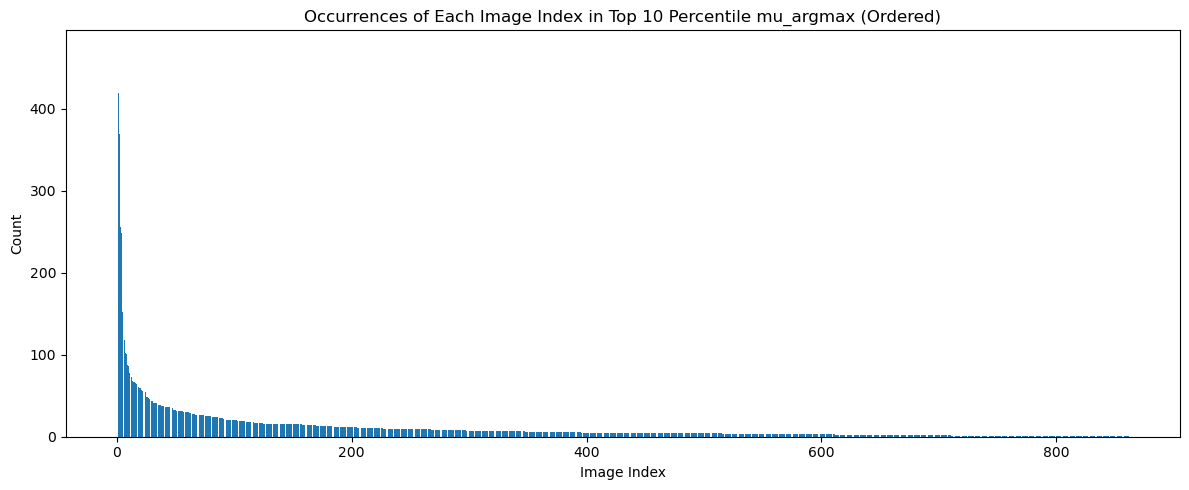

84.28% of images appear at least once in the top 10 percentile (863/1024).
Top 1% (10/1024) cover 23.64% (2324/9831) of all top 10 percentile occurrences.
Top 5% (51/1024) cover 43.87% (4313/9831) of all top 10 percentile occurrences.
Top 10% (102/1024) cover 57.12% (5615/9831) of all top 10 percentile occurrences.


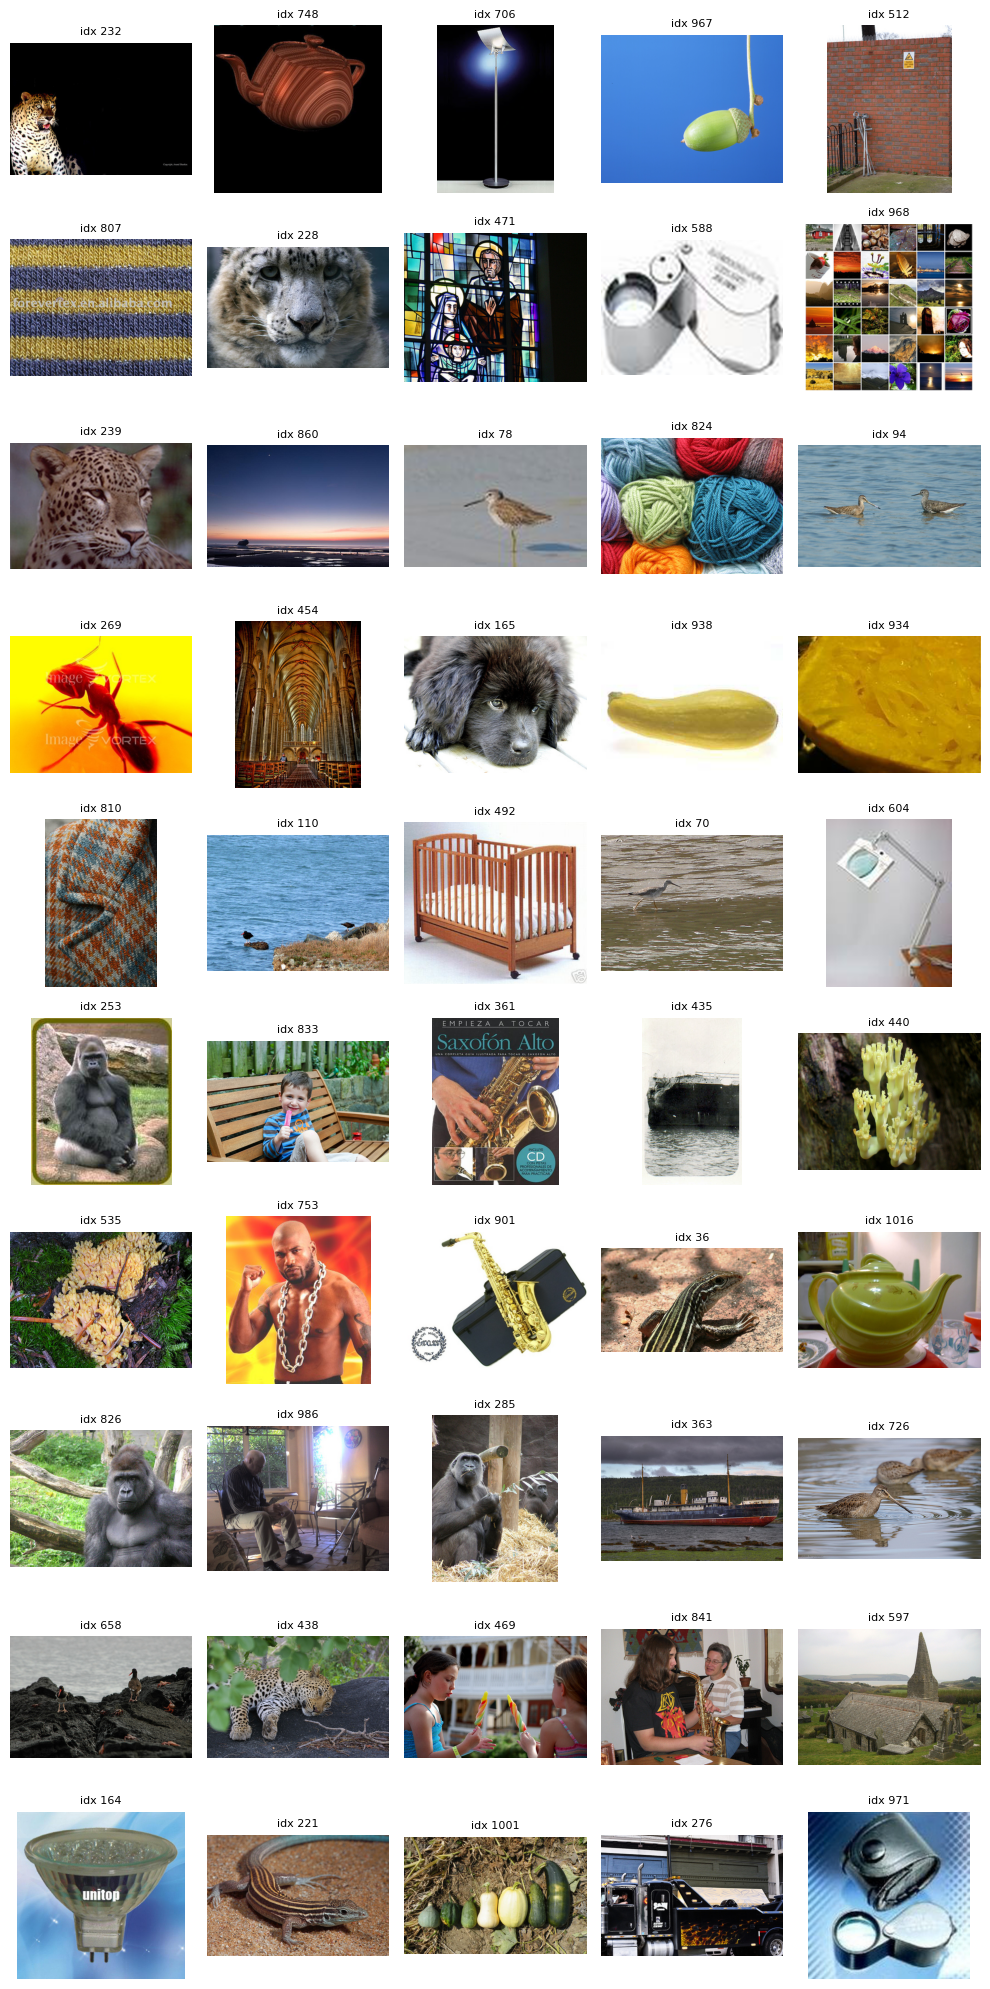

In [24]:
import collections

mu_argmax_values = np.concatenate(agg_data['mu_argmax'].values)
mu_argmax_values_top_10 = np.concatenate(agg_data['top_10_percentile_mu_argmax'].values)
print(max(mu_argmax_values), max(mu_argmax_values_top_10))
print(len(mu_argmax_values), len(mu_argmax_values_top_10))

value_counts = collections.Counter(mu_argmax_values)
print(len(value_counts))
value_counts_top_10 = collections.Counter(mu_argmax_values_top_10)
# Order by count descending
ordered = value_counts_top_10.most_common()
values, counts = zip(*ordered)

plt.figure(figsize=(12, 5))
plt.bar(range(len(counts)), counts)
plt.xlabel('Image Index')
plt.ylabel('Count')
plt.title('Occurrences of Each Image Index in Top 10 Percentile mu_argmax (Ordered)')
plt.tight_layout()
plt.show()

img_cnt = num_classes * num_per_class
print(f"{len(values)/img_cnt:.2%} of images appear at least once in the top 10 percentile ({len(values)}/{img_cnt}).")
for precentage in [1, 5, 10]:
    top_n = int(img_cnt * precentage / 100)
    print(f"Top {precentage}% ({top_n}/{img_cnt}) cover {sum(counts[:top_n])/len(mu_argmax_values_top_10):.2%} ({sum(counts[:top_n])}/{len(mu_argmax_values_top_10)}) of all top 10 percentile occurrences.")

imgs = [ds_by_index[i][0].permute(1, 2, 0).cpu().numpy() for i in values[:25]]
imgs.extend([ds_by_index[i][0].permute(1, 2, 0).cpu().numpy() for i in values[-25:]])


fig, axs = plt.subplots(len(imgs)//5, 5, figsize=(10, 2*len(imgs)//5))
for i, img in enumerate(imgs):
    axs[i // 5, i % 5].imshow((img + 1) / 2.)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"idx {values[i]}", fontsize=8)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1232930/2931342604.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  block_df = weighted.groupby('layer_num', group_keys=False).apply(
/tmp/ipykernel_1232930/2931342604.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  type_df = agg_data.groupby('layer_type', group_keys=False).apply(


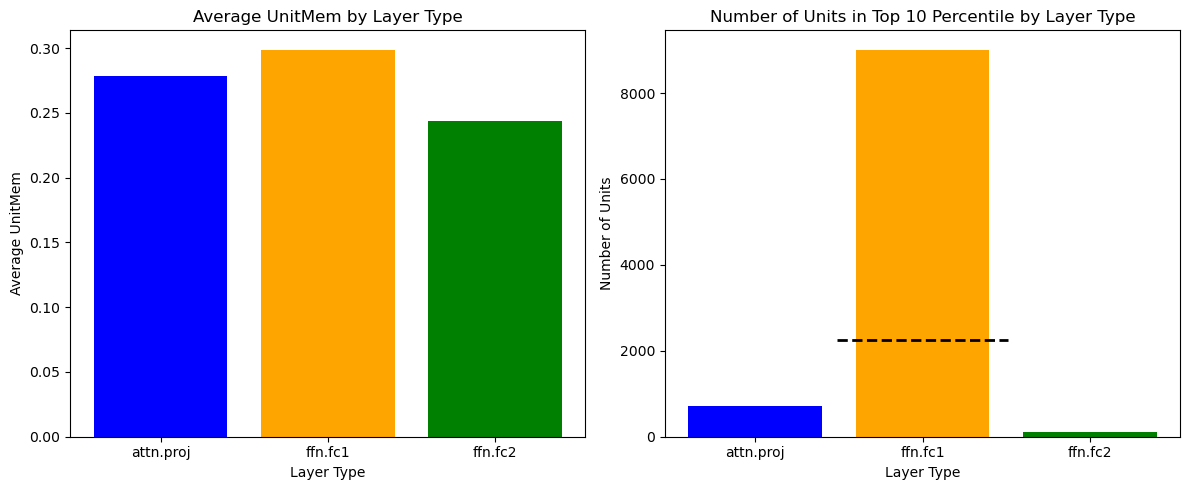

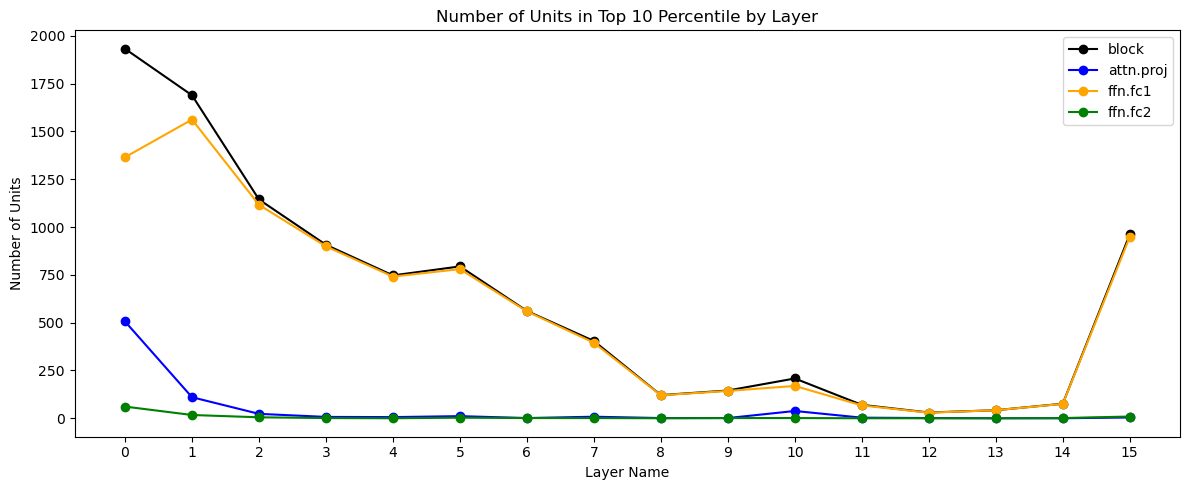

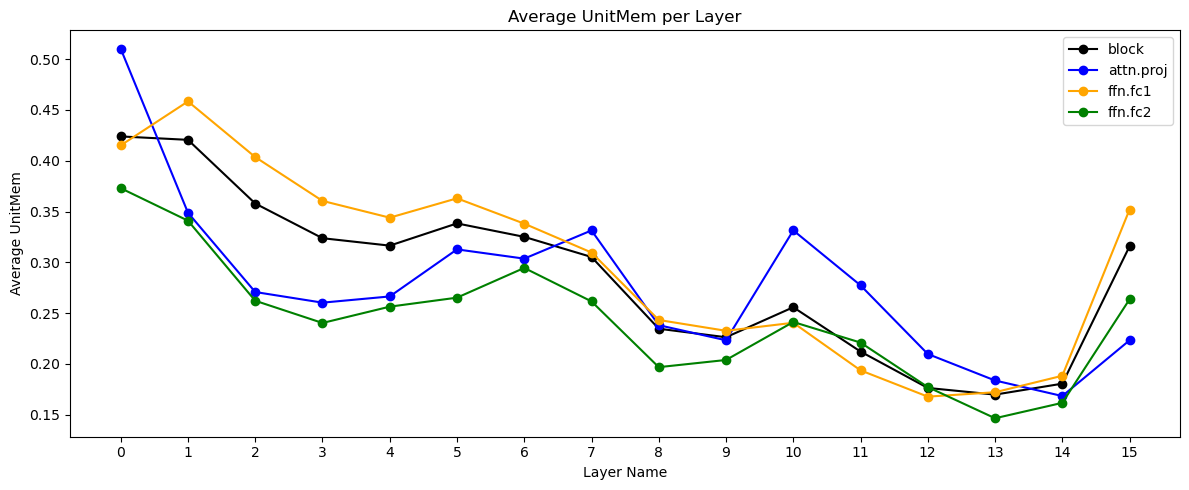

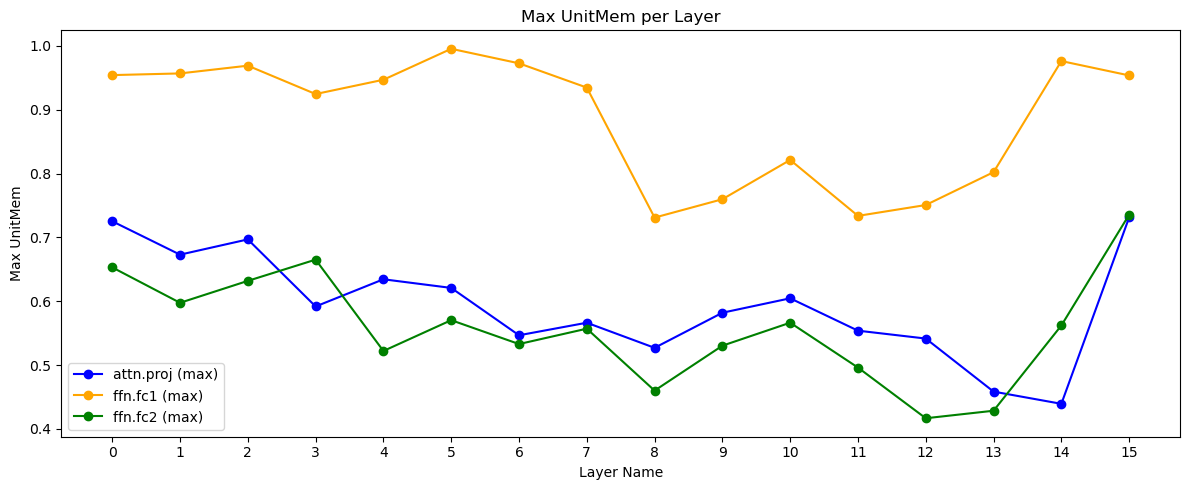

In [28]:

# Average avg_unit_mem for each layer_num, weighting 'ffn.fc1' 4 times
weighted = agg_data.copy()
weighted['weight'] = weighted['layer_type'].apply(lambda x: 4 if x == 'ffn.fc1' else 1)
block_df = weighted.groupby('layer_num', group_keys=False).apply(
    lambda g: pd.Series({
        "weighted_avg_unit_mem": np.average(g['avg_unit_mem'], weights=g['weight']),
        "sum_top_10_percentile_count": np.sum(g['top_10_percentile_count']),
    })
).reset_index()
type_df = agg_data.groupby('layer_type', group_keys=False).apply(
    lambda g: pd.Series({
        "avg_avg_unit_mem": np.average(g['avg_unit_mem']),
        "sum_top_10_percentile_count": np.sum(g['top_10_percentile_count']),
    })
).reset_index()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First plot: avg_avg_unit_mem for layer types
axs[0].bar(type_df['layer_type'], type_df['avg_avg_unit_mem'], color=['blue', 'orange', 'green'])
axs[0].set_title('Average UnitMem by Layer Type')
axs[0].set_xlabel('Layer Type')
axs[0].set_ylabel('Average UnitMem')

# Second plot: sum_top_10_percentile_count for layer types
axs[1].bar(type_df['layer_type'], type_df['sum_top_10_percentile_count'], color=['blue', 'orange', 'green'])
ffn_fc1_val = type_df[type_df['layer_type'] == 'ffn.fc1']['sum_top_10_percentile_count'].values[0]
axs[1].axhline(ffn_fc1_val / 4, color='black', linestyle='--', linewidth=2,
               xmin=1/3, xmax=2/3,
               label='adjusted for the size of ffn.fc1')
axs[1].set_title('Number of Units in Top 10 Percentile by Layer Type')
axs[1].set_xlabel('Layer Type')
axs[1].set_ylabel('Number of Units')

plt.tight_layout()
plt.show()

attn_proj_filter = agg_data['layer_type'] == 'attn.proj'
ffn_fc1_filter = agg_data['layer_type'] == 'ffn.fc1'
ffn_fc2_filter = agg_data['layer_type'] == 'ffn.fc2'


plt.figure(figsize=(12, 5))
plt.plot(block_df['layer_num'], block_df['sum_top_10_percentile_count'], label='block', marker='o', color='black')
plt.plot(agg_data['layer_num'][attn_proj_filter], agg_data['top_10_percentile_count'][attn_proj_filter], label='attn.proj', marker='o', color='blue')
plt.plot(agg_data['layer_num'][ffn_fc1_filter], agg_data['top_10_percentile_count'][ffn_fc1_filter], label='ffn.fc1', marker='o', color='orange')
plt.plot(agg_data['layer_num'][ffn_fc2_filter], agg_data['top_10_percentile_count'][ffn_fc2_filter], label='ffn.fc2', marker='o', color='green')
plt.legend()
plt.xticks(range(agg_data['layer_num'].min(), agg_data['layer_num'].max()+1))
plt.title('Number of Units in Top 10 Percentile by Layer')
plt.xlabel('Layer Name')
plt.ylabel('Number of Units')
plt.tight_layout()
plt.show()

# Line plot of avg_unit_mem per layer
plt.figure(figsize=(12, 5))
plt.plot(block_df['layer_num'], block_df['weighted_avg_unit_mem'], label='block', marker='o', color='black')
plt.plot(agg_data['layer_num'][attn_proj_filter], agg_data['avg_unit_mem'][attn_proj_filter], label='attn.proj', marker='o', color='blue')
plt.plot(agg_data['layer_num'][ffn_fc1_filter], agg_data['avg_unit_mem'][ffn_fc1_filter], label='ffn.fc1', marker='o', color='orange')
plt.plot(agg_data['layer_num'][ffn_fc2_filter], agg_data['avg_unit_mem'][ffn_fc2_filter], label='ffn.fc2', marker='o', color='green')
plt.legend()
plt.xticks(range(agg_data['layer_num'].min(), agg_data['layer_num'].max()+1))
plt.title('Average UnitMem per Layer')
plt.xlabel('Layer Name')
plt.ylabel('Average UnitMem')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(agg_data['layer_num'][attn_proj_filter], agg_data['max_unit_mem'][attn_proj_filter], label='attn.proj (max)', marker='o', color='blue')
plt.plot(agg_data['layer_num'][ffn_fc1_filter], agg_data['max_unit_mem'][ffn_fc1_filter], label='ffn.fc1 (max)', marker='o', color='orange')
plt.plot(agg_data['layer_num'][ffn_fc2_filter], agg_data['max_unit_mem'][ffn_fc2_filter], label='ffn.fc2 (max)', marker='o', color='green')
plt.legend()
plt.xticks(range(agg_data['layer_num'].min(), agg_data['layer_num'].max()+1))
plt.title('Max UnitMem per Layer')
plt.xlabel('Layer Name')
plt.ylabel('Max UnitMem')
plt.tight_layout()
plt.show()

In [29]:
layer_nums = [0, 5, 10, 15]
for row in agg_data[agg_data['layer_num'] == 5].itertuples():
    max_in_type = np.argsort(row.unit_mem)[-5:][::-1]
    print(f"Layer: {row.layer_name}, top 5 indices in unit_mem: {max_in_type}, values: {[row.unit_mem[i] for i in max_in_type]}")

Layer: blocks.05.attn.proj, top 5 indices in unit_mem: [585 799 257 213 951], values: [np.float32(0.62078345), np.float32(0.6008711), np.float32(0.57897925), np.float32(0.5776649), np.float32(0.5718645)]
Layer: blocks.05.ffn.fc1, top 5 indices in unit_mem: [1772  274 3753 3867 1465], values: [np.float32(0.9953303), np.float32(0.94935566), np.float32(0.939088), np.float32(0.92374426), np.float32(0.9180646)]
Layer: blocks.05.ffn.fc2, top 5 indices in unit_mem: [996  37 889 155 257], values: [np.float32(0.5702651), np.float32(0.5530672), np.float32(0.5477241), np.float32(0.4980656), np.float32(0.4913928)]


Layer Num: 0
Layer: 0, top 10 indices in unit_mem: [2550  710 1692   32 3055 2209 1076 3344 2833 1255], values: [np.float32(0.95413834), np.float32(0.9457056), np.float32(0.93195033), np.float32(0.91941667), np.float32(0.9173167), np.float32(0.9132077), np.float32(0.9111072), np.float32(0.90897524), np.float32(0.9085082), np.float32(0.90846)]


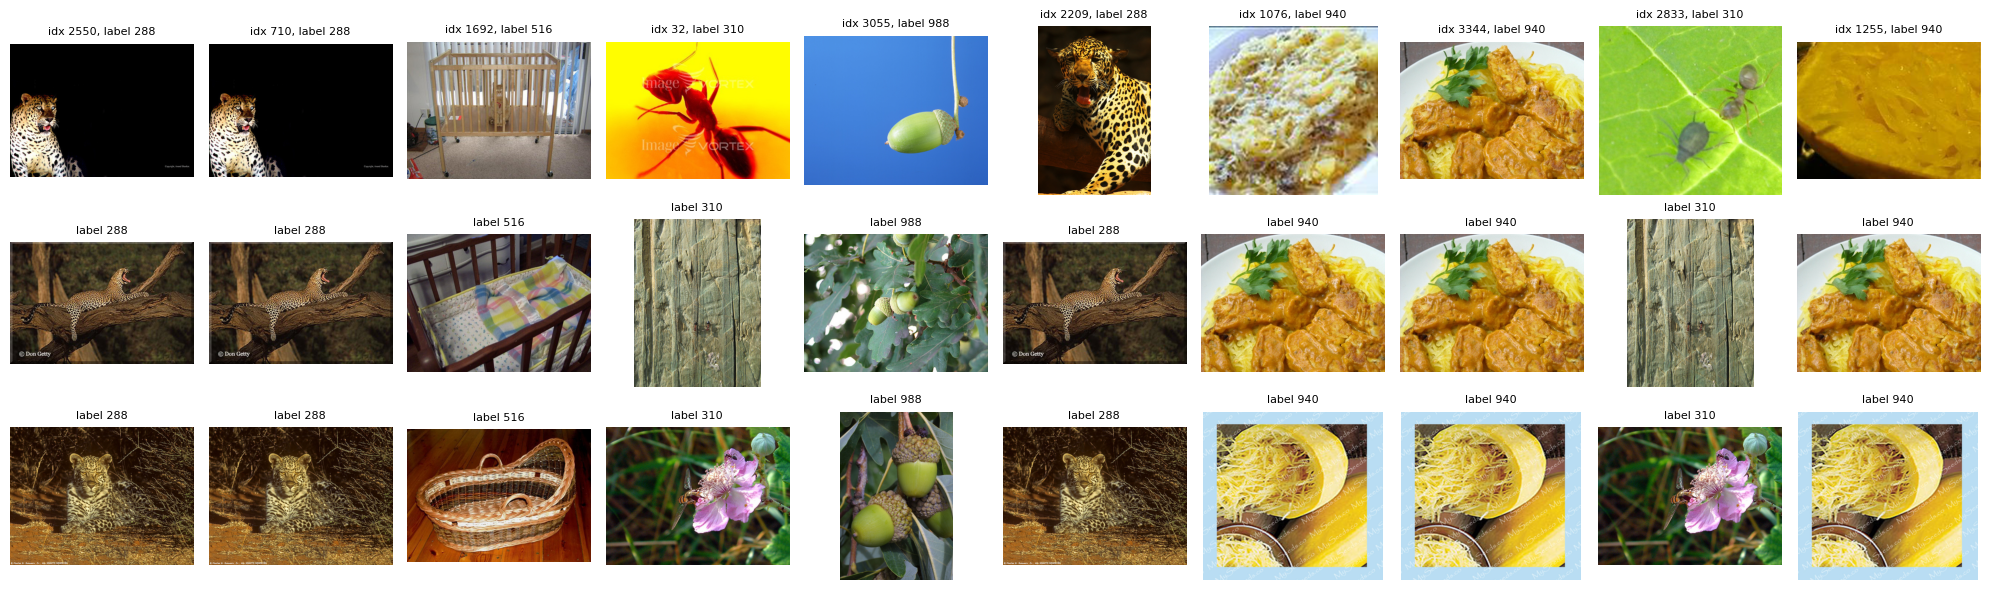

Layer Num: 5
Layer: 5, top 10 indices in unit_mem: [1772  274 3753 3867 1465 2882 2126  388  110 2792], values: [np.float32(0.9953303), np.float32(0.94935566), np.float32(0.939088), np.float32(0.92374426), np.float32(0.9180646), np.float32(0.9110463), np.float32(0.89602476), np.float32(0.8946661), np.float32(0.89370185), np.float32(0.8863465)]


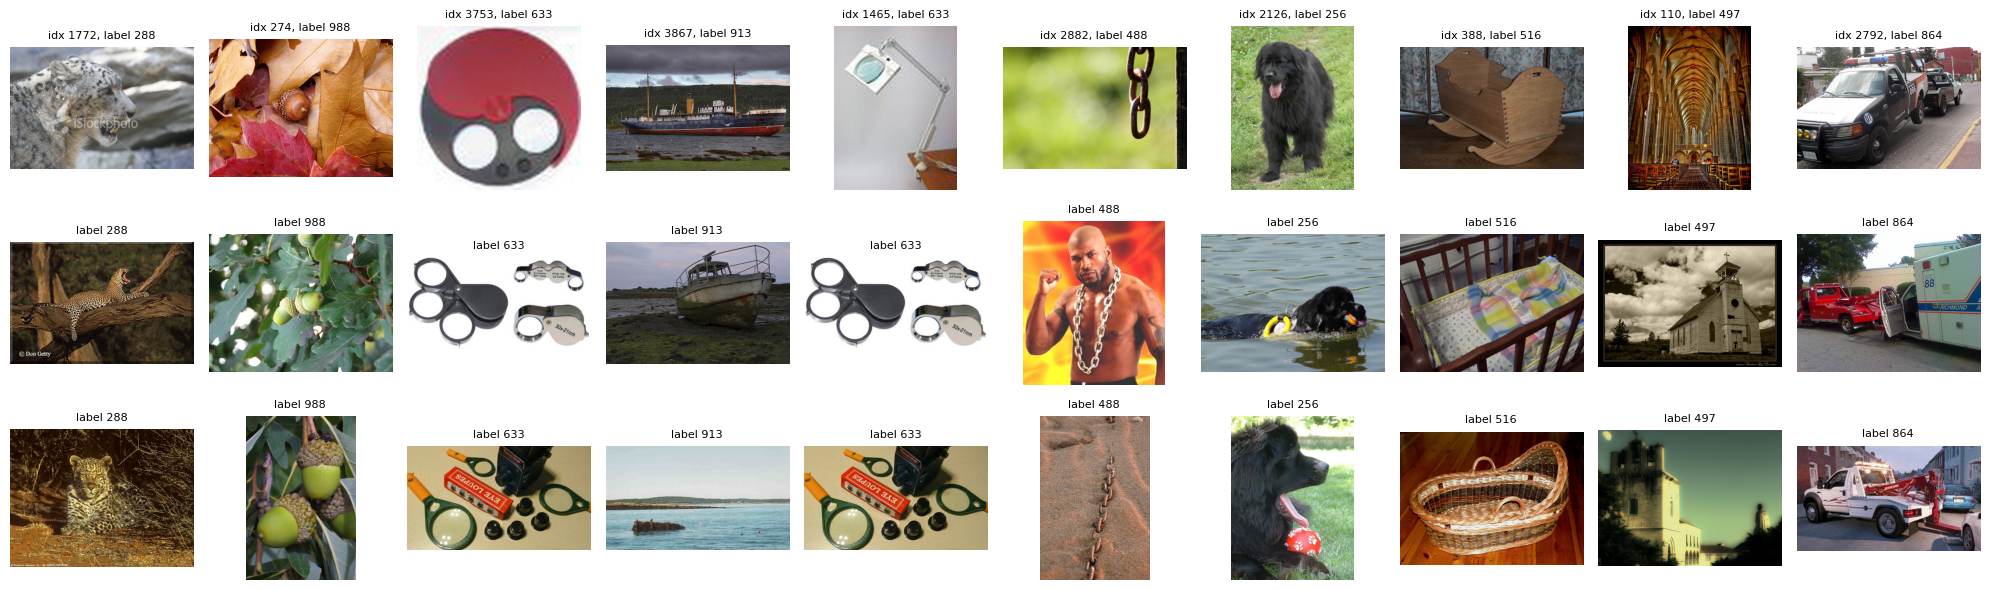

Layer Num: 10
Layer: 10, top 10 indices in unit_mem: [2801 1217 1162 1165  134 2194 2479  169  323 3983], values: [np.float32(0.8212566), np.float32(0.80145705), np.float32(0.7430419), np.float32(0.7318324), np.float32(0.7284257), np.float32(0.71709687), np.float32(0.71403474), np.float32(0.71159905), np.float32(0.7001934), np.float32(0.69069445)]


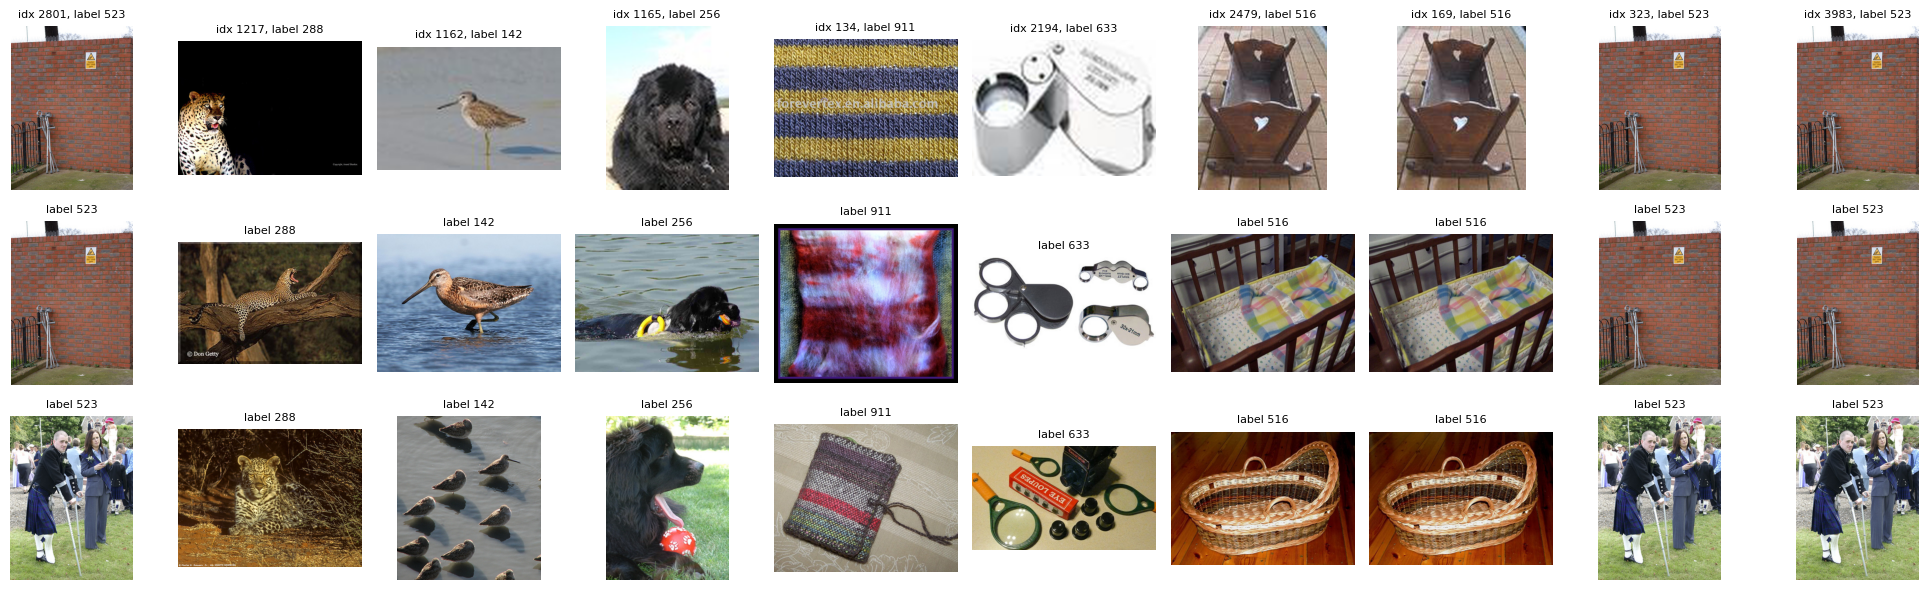

Layer Num: 15
Layer: 15, top 10 indices in unit_mem: [2962  247 1042 1949 2516 3197 2767 2729 3902 3474], values: [np.float32(0.95361936), np.float32(0.93069893), np.float32(0.92012143), np.float32(0.9167402), np.float32(0.91336894), np.float32(0.9066726), np.float32(0.9029243), np.float32(0.90142596), np.float32(0.8994012), np.float32(0.8976568)]


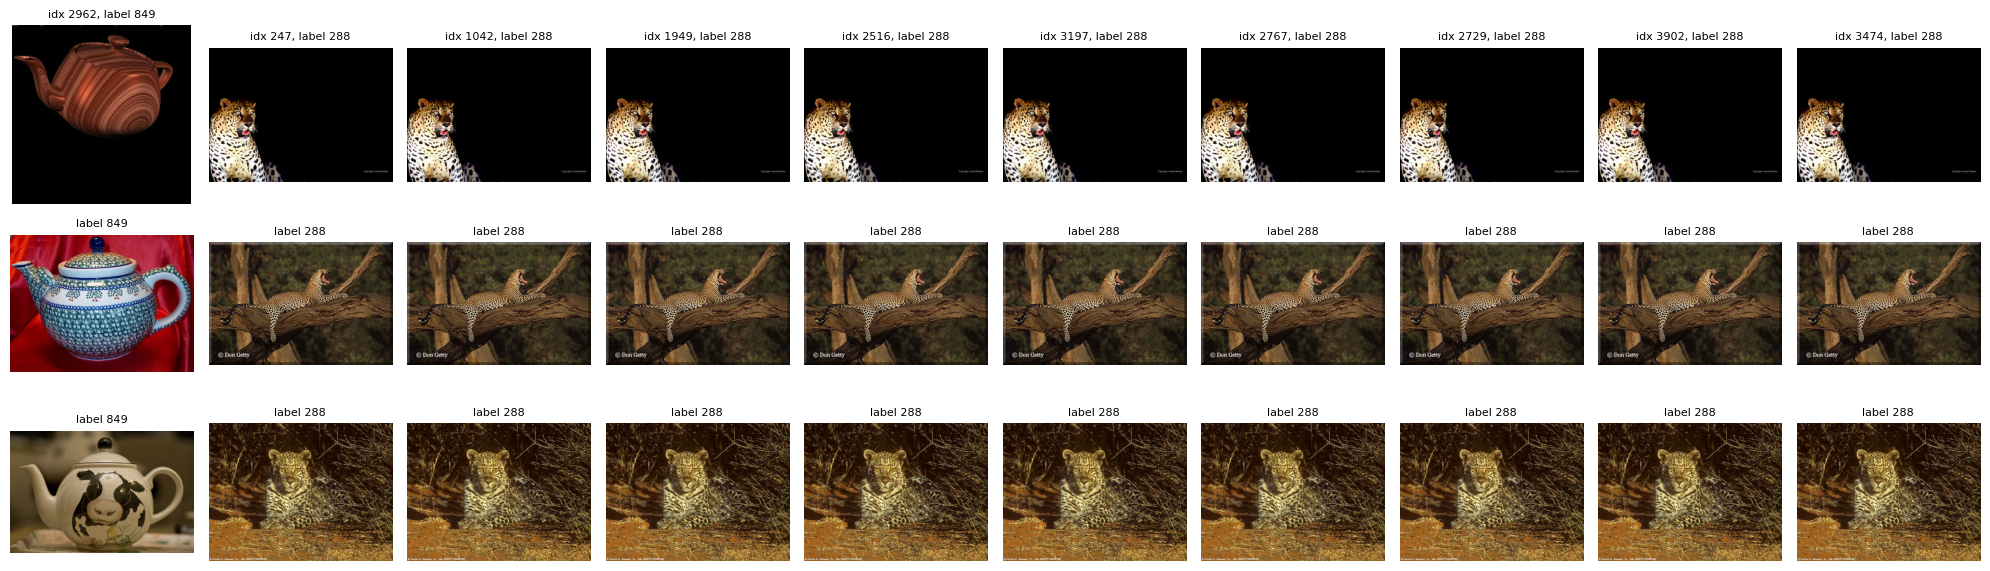

In [30]:
layer_nums = [0, 5, 10, 15]
num_top = 10
for layer_num in layer_nums:
    print(f"Layer Num: {layer_num}")
    row = agg_data[(agg_data['layer_num'] == layer_num) & (agg_data['layer_type'] == 'ffn.fc1')].iloc[0]
    unit_mem = row['unit_mem']
    max_in_type = np.argsort(unit_mem)[-num_top:][::-1]
    print(f"Layer: {layer_num}, top {num_top} indices in unit_mem: {max_in_type}, values: {[unit_mem[i] for i in max_in_type]}")
    image_indices = row['mu_argmax'][max_in_type]
    images = [ds_by_index[i] for i in image_indices]
    
    shown_per_class = 2
    fig, axs = plt.subplots(1 + shown_per_class, num_top, figsize=(num_top*2, (1+shown_per_class)*2))
    for idx in range(num_top):
        if idx < len(images):
            img, label = images[idx]
            img = img.permute(1, 2, 0).cpu().numpy()
            axs[0, idx].imshow((img + 1) / 2.)
            axs[0, idx].axis('off')
            axs[0, idx].set_title(f"idx {max_in_type[idx]}, label {label}", fontsize=8)
            # Cache datasets per class label
            if 'class_datasets_cache' not in globals():
                class_datasets_cache = {}
            if label not in class_datasets_cache:
                class_datasets_cache[label] = get_datasets(IMAGENET_PATH, num_per_class, [label], 1, no_crop=True)[0]
            ds_class = class_datasets_cache[label]
            for j in range(shown_per_class):
                img_j, label_j = ds_class[j]
                img_j = img_j.permute(1, 2, 0).cpu().numpy()
                axs[j + 1, idx].imshow((img_j + 1) / 2.)
                axs[j + 1, idx].axis('off')
                axs[j + 1, idx].set_title(f"label {label_j}", fontsize=8)
        else:
            for j in range(1 + shown_per_class):
                axs[j, idx].axis('off')
    plt.tight_layout()
    plt.show()